[← Back to Index](../index)

# Comparing signals in the time domain

Given time-series signal `a` and signal `b`, how can we compare them to one another? Are they the same? How do we define "same" or "similarity"?

One naive approach may be to enumerate each value in `a` and compare it to the corresponding value in `b`? But what should our comparison function be? Perhaps the simplest way is by subtraction (or take the absolute difference between $a_i$ and $b_i$). Can we do better?

Let's explore some common approaches below.


## Dependencies

This notebook requires [FastDTW](https://pypi.org/project/fastdtw/)—a python package for performing Dynamic Time Warping (DTW). To install this package, you have **two** options. 

First, from within Notebook, you can execute the following two lines within a cell (you'll only need to run this once):

```
import sys
!{sys.executable} -m pip install fastdtw
```

Second, from within your Anaconda shell:

```
> conda install -c conda-forge fastdtw
```

## Resources

- [Music synchronization (Jupyter Notebook)](https://musicinformationretrieval.com/#Music-Synchronization), Steve Tjoa
- [Four ways to quantify synchrony between time series data](https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9), Towards Data Science, Jin Hyun Cheong, May 2019

## About this Notebook

This Notebook was designed and written by Professor Jon E. Froehlich at the University of Washington along with feedback from students. It is made available freely online as an [open educational resource](https://en.wikipedia.org/wiki/Open_educational_resources) at the teaching website: https://makeabilitylab.github.io/physcomp/. 

The [website](https://github.com/makeabilitylab/physcomp), [Notebook code](https://github.com/makeabilitylab/signals), and [Arduino code](https://github.com/makeabilitylab/arduino) are all open source using the MIT license.

Please file a GitHub Issue or Pull Request for changes/comments or email me directly.


# Main imports

In [40]:
import matplotlib.pyplot as plt # matplot lib is the premiere plotting lib for Python: https://matplotlib.org/
import numpy as np # numpy is the premiere signal handling library for Python: http://www.numpy.org/
import scipy as sp # for signal processing
from scipy import signal
from scipy.spatial import distance
import IPython.display as ipd
import librosa
import random
import math
import makelab
from makelab import audio
from makelab import signal

# Utility functions

In [41]:
def pad_zeros_right(s, padding_length):
    # https://numpy.org/doc/1.18/reference/generated/numpy.pad.html
    return np.pad(s, (0, padding_length), mode = 'constant', constant_values=0)

def pad_mean_right(s, padding_length):
    # https://numpy.org/doc/1.18/reference/generated/numpy.pad.html
    return np.pad(s, (0, padding_length), mode = 'mean')

# def compare_and_plot_signals(a, b, distance_function = distance.euclidean, alignment_function = None):
def plot_signals_with_alignment(a, b, pad_function = None):
    if(len(a) != len(b) and pad_function is None):
        raise Exception(f"Signal 'a' and 'b' must be the same size; len(a)={len(a)} and len(b)={len(b)} or pad_function must not be None")
    elif(len(a) != len(b) and pad_function is not None):
        if(len(a) < len(b)):
            a = pad_function(a, len(b) - len(a))
        else:
            b = pad_function(b, len(a) - len(b))
    
    correlate_result = np.correlate(a, b, 'full')
    shift_positions = np.arange(-len(a) + 1, len(b))
    
    print("len(a)", len(a), "len(b)", len(b), "len(correlate_result)", len(correlate_result))

    fig, axes = plt.subplots(5, 1, figsize=(10, 18))
    
    axes[0].plot(a, alpha=0.7, label="a", marker="o")
    axes[0].plot(b, alpha=0.7, label="b", marker="D")
    axes[0].legend()
    axes[0].set_title("Raw Signals 'a' and 'b'")
    
    if len(shift_positions) < 20:
        # useful for debugging and showing correlation results
        print(shift_positions)
        print(correlate_result)

    best_correlation_index = np.argmax(correlate_result)
    shift_amount_debug = shift_positions[best_correlation_index]
    shift_amount = (-len(a) + 1) + best_correlation_index
    print("best_correlation_index", best_correlation_index, "shift_amount_debug", shift_amount_debug, "shift_amount", shift_amount)
    
    axes[1].stem(shift_positions, correlate_result, use_line_collection=True, label="Cross-correlation of a and b")
    axes[1].set_title(f"Cross-Correlation Result | Best Match Index: {best_correlation_index} Signal 'b' Shift Amount: {shift_amount}")
    axes[1].set_ylabel("Cross Correlation")
    axes[1].set_xlabel("'b' Signal Shift Amount")
    
    best_match_ymin = 0
    best_match_ymin_normalized = makelab.signal.map(best_match_ymin, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    best_match_ymax = correlate_result[best_correlation_index]
    best_match_ymax_normalized = makelab.signal.map(best_match_ymax, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    axes[1].axvline(shift_positions[best_correlation_index], ymin=best_match_ymin_normalized, ymax=best_match_ymax_normalized, 
                    linewidth=2, color='orange', alpha=0.8, linestyle='-.', 
                    label=f"Best match ({shift_amount}, {best_match_ymax:.2f})")
    axes[1].legend()
    
    b_shifted_mean_fill = makelab.signal.shift_array(b, shift_amount, np.mean(b))
    axes[2].plot(a, alpha=0.7, label="a", marker="o")
    axes[2].plot(b_shifted_mean_fill, alpha=0.7, label="b_shifted_mean_fill", marker="D")
    axes[2].legend()
    axes[2].set_title("Signals 'a' and 'b_shifted_mean_fill'")
    
    b_shifted_zero_fill = makelab.signal.shift_array(b, shift_amount, 0)
    axes[3].plot(a, alpha=0.7, label="a", marker="o")
    axes[3].plot(b_shifted_zero_fill, alpha=0.7, label="b_shifted_zero_fill", marker="D")
    axes[3].legend()
    axes[3].set_title("Signals 'a' and 'b_shifted_zero_fill'")
    
    b_shifted_roll = np.roll(b, shift_amount)
    axes[4].plot(a, alpha=0.7, label="a", marker="o")
    axes[4].plot(b_shifted_roll, alpha=0.7, label="b_shifted_roll", marker="D")
    axes[4].legend()
    axes[4].set_title("Signals 'a' and 'b_shifted_roll'")
    
    fig.tight_layout()
    
def compare_and_plot_signals_with_alignment(a, b, bshift_method = 'mean_fill', pad_function = None):
    '''Aligns signals using cross correlation and then plots
    
       bshift_method can be: 'mean_fill', 'zero_fill', 'roll', or 'all'. Defaults to 'mean_fill'
    '''
    
    if(len(a) != len(b) and pad_function is None):
        raise Exception(f"Signal 'a' and 'b' must be the same size; len(a)={len(a)} and len(b)={len(b)} or pad_function must not be None")
    elif(len(a) != len(b) and pad_function is not None):
        if(len(a) < len(b)):
            a = pad_function(a, len(b) - len(a))
        else:
            b = pad_function(b, len(a) - len(b))
    
    correlate_result = np.correlate(a, b, 'full')
    shift_positions = np.arange(-len(a) + 1, len(b))
    print("len(a)", len(a), "len(b)", len(b), "len(correlate_result)", len(correlate_result))
    
    euclid_distance_a_to_b = distance.euclidean(a, b)
    
    num_charts = 3
    chart_height = 3.6
    if bshift_method is 'all':
        num_charts = 5
    
    fig, axes = plt.subplots(num_charts, 1, figsize=(10, num_charts * chart_height))
    
    # Turn on markers only if < 50 points
    a_marker = None
    b_marker = None
    if len(a) < 50:
        a_marker = "o"
        b_marker = "D"
        
    axes[0].plot(a, alpha=0.7, label="a", marker=a_marker)
    axes[0].plot(b, alpha=0.7, label="b", marker=b_marker)
    axes[0].legend()
    axes[0].set_title(f"Raw Signals | Euclidean Distance From 'a' to 'b' = {euclid_distance_a_to_b:.2f}")
    
    if len(shift_positions) < 20:
        # useful for debugging and showing correlation results
        print(shift_positions)
        print(correlate_result)
    
    best_correlation_index = np.argmax(correlate_result)
    shift_amount_debug = shift_positions[best_correlation_index]
    shift_amount = (-len(a) + 1) + best_correlation_index
    print("best_correlation_index", best_correlation_index, "shift_amount_debug", shift_amount_debug, "shift_amount", shift_amount)
    
    #axes[1].plot(shift_positions, correlate_result)
    axes[1].stem(shift_positions, correlate_result, use_line_collection=True, label="Cross-correlation of a and b")
    axes[1].set_title(f"Cross-correlation result | Best match index: {best_correlation_index}; Signal 'b' shift amount: {shift_amount}")
    axes[1].set_ylabel("Cross Correlation")
    axes[1].set_xlabel("'b' Signal Shift Amount")
    
    best_match_ymin = 0
    best_match_ymin_normalized = makelab.signal.map(best_match_ymin, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    best_match_ymax = correlate_result[best_correlation_index]
    best_match_ymax_normalized = makelab.signal.map(best_match_ymax, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    axes[1].axvline(shift_positions[best_correlation_index], ymin=best_match_ymin_normalized, ymax=best_match_ymax_normalized, 
                    linewidth=2, color='orange', alpha=0.8, linestyle='-.', 
                    label=f"Best match ({shift_amount}, {best_match_ymax:.2f})")
    axes[1].legend()
    
    if bshift_method is 'mean_fill' or bshift_method is 'all':
        b_shifted_mean_fill = makelab.signal.shift_array(b, shift_amount, np.mean(b))
        euclid_distance_a_to_b_shifted_mean_fill = distance.euclidean(a, b_shifted_mean_fill)
        axes[2].plot(a, alpha=0.7, label="a", marker=a_marker)
        axes[2].plot(b_shifted_mean_fill, alpha=0.7, label="b_shifted_mean_fill", marker=b_marker)
        axes[2].legend()
        axes[2].set_title(f"Euclidean distance From 'a' to 'b_shifted_mean_fill' = {euclid_distance_a_to_b_shifted_mean_fill:.2f}")
    
    ax_idx = 0
    if bshift_method is 'zero_fill' or bshift_method is 'all':
        if bshift_method is 'zero_fill':
            ax_idx = 2
        else:
            ax_idx = 3
    
        b_shifted_zero_fill = makelab.signal.shift_array(b, shift_amount, 0)
        euclid_distance_a_to_b_shifted_zero_fill = distance.euclidean(a, b_shifted_zero_fill)
        axes[ax_idx].plot(a, alpha=0.7, label="a", marker=a_marker)
        axes[ax_idx].plot(b_shifted_zero_fill, alpha=0.7, label="b_shifted_zero_fill", marker=b_marker)
        axes[ax_idx].legend()
        axes[ax_idx].set_title(f"Euclidean distance From 'a' to 'b_shifted_zero_fill' = {euclid_distance_a_to_b_shifted_zero_fill:.2f}")
    
    
    if bshift_method is 'roll' or bshift_method is 'all':
        if bshift_method is 'roll':
            ax_idx = 2
        else:
            ax_idx = 4
        b_shifted_roll = np.roll(b, shift_amount)
        euclid_distance_a_to_b_shifted_roll = distance.euclidean(a, b_shifted_roll)
        axes[ax_idx].plot(a, alpha=0.7, label="a", marker=a_marker)
        axes[ax_idx].plot(b_shifted_roll, alpha=0.7, label="b_shifted_roll", marker=b_marker)
        axes[ax_idx].legend()
        axes[ax_idx].set_title(f"Euclidean distance From 'a' to 'b_shifted_roll' = {euclid_distance_a_to_b_shifted_roll:.2f}")
    
    fig.tight_layout()
    

    

# Euclidean distance

The Euclidean distance between two points $p$ and $q$ is the length of the line segment between them. 

For a two signals `a` and `b`, we can enumerate through the arrays and compute the Euclidean distance between each point. More formally:

$d\left(a,b\right)   = \sqrt {\sum _{i=1}^{n}  \left( a_{i}-b_{i}\right)^2 }$ 

Let's try it out!


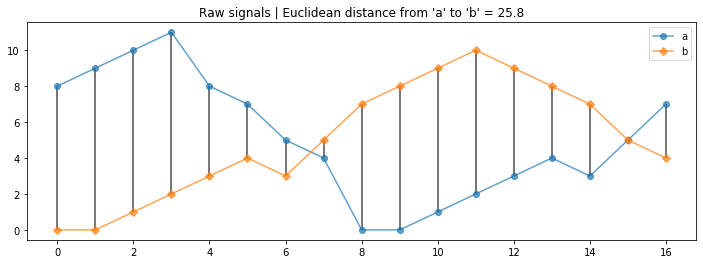

In [42]:
a = [8, 9, 10, 11, 8, 7, 5, 4, 0, 0, 1, 2, 3, 4, 3, 5, 7]
b = [0, 0, 1, 2, 3, 4, 3, 5, 7, 8, 9, 10, 9, 8, 7, 5, 4]

euclid_distance_a_to_b = distance.euclidean(a, b)

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.plot(a, alpha=0.7, label="a", marker="o")
axes.plot(b, alpha=0.7, label="b", marker="D")

# draw connecting segments between a_i and b_i used for Euclidean distance calculation
axes.vlines(np.arange(0, len(a), 1), a, b, alpha = 0.7)
axes.legend()
axes.set_title("Raw signals | Euclidean distance from 'a' to 'b' = {:0.1f}".format(euclid_distance_a_to_b));

Now with some random data.

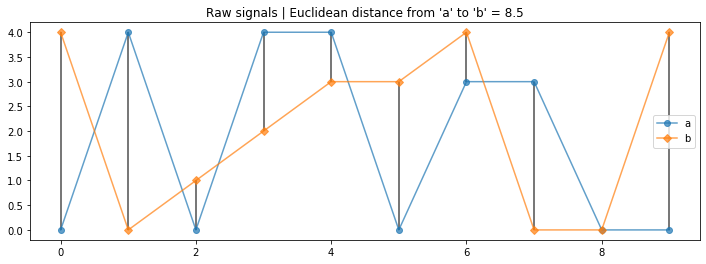

In [43]:
np.random.seed(None)
a = np.random.randint(0, 5, 10)
b = np.random.randint(0, 5, 10)

euclid_distance_a_to_b = distance.euclidean(a, b)

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.plot(a, alpha=0.7, label="a", marker="o")
axes.plot(b, alpha=0.7, label="b", marker="D")

# draw connecting segments between a_i and b_i used for Euclidean distance calculation
axes.vlines(np.arange(0, len(a), 1), a, b, alpha = 0.7)
axes.legend()
axes.set_title("Raw signals | Euclidean distance from 'a' to 'b' = {:0.1f}".format(euclid_distance_a_to_b));

## Comparing signals of two different lengths

If the two signals are different lengths, `distance.euclidean` will throw an exception:

```
ValueError: operands could not be broadcast together with shapes
```

For example, the following cell will throw an exception.

In [44]:
# This cell will throw an error demonstrating that distance.euclidean
# only works with the same sized arrays

a = [0, 1, 2, 3, 4, 5, 6, 7]
b = [3, 4, 5]
euclid_distance_a_to_b = distance.euclidean(a, b)

ValueError: operands could not be broadcast together with shapes (8,) (3,) 

### Padding signals

So, what should we do? We have two options:
- **Trim** the longer signal to be the same size as the shorter signal (but we obviously risk information loss here)
- **Expand** the shorter signal to be the same size as the longer signal. But then what values should we use for this expansion?

Typically, the latter approach is used and NumPy has a method for this called [`numpy.pad`](https://numpy.org/doc/1.18/reference/generated/numpy.pad.html), which allows you to select from a variety of methods to pad your signal. You can pad both the left and right edge, you can pad with a constant value or some statistic (the `mean` or the `maximum`), *etc.*

You need to decide on the best padding approach given your signal and problem domain.

In [45]:
a = [0, 1, 2, 3, 4, 5, 6, 7]
b = [3, 4, 5]

padding_length = len(a) - len(b)

# Pad using zero to the right of the array
b_padded_zero_right = np.pad(b, (0, padding_length), mode = 'constant', constant_values=0)
print(a, len(a))
print(b, len(b))
print(b_padded_zero_right, len(b_padded_zero_right))

[0, 1, 2, 3, 4, 5, 6, 7] 8
[3, 4, 5] 3
[3 4 5 0 0 0 0 0] 8


In [46]:
# Pad with constant value zero to left of the array
b_padded_zero_left = np.pad(b, (padding_length, 0), mode = 'constant', constant_values=0)

print(a, len(a))
print(b, len(b))
print(b_padded_zero_left, len(b_padded_zero_left))

[0, 1, 2, 3, 4, 5, 6, 7] 8
[3, 4, 5] 3
[0 0 0 0 0 3 4 5] 8


In [47]:
# Pad with zero in both directions
b_padded_zero_bothdirs = np.pad(b, (math.floor(padding_length/2.0), math.ceil(padding_length/2.0)), 
                                mode = 'constant', constant_values=0)
print(a, len(a))
print(b, len(b))
print(b_padded_zero_bothdirs, len(b_padded_zero_bothdirs))

[0, 1, 2, 3, 4, 5, 6, 7] 8
[3, 4, 5] 3
[0 0 3 4 5 0 0 0] 8


In [48]:
# Pad to the right with the mean of 'b'
b_padded_mean_right = np.pad(b, (0, padding_length), mode = 'mean')

print(a, len(a))
print(b, len(b))
print(b_padded_mean_right, len(b_padded_mean_right))

[0, 1, 2, 3, 4, 5, 6, 7] 8
[3, 4, 5] 3
[3 4 5 4 4 4 4 4] 8


See the [numpy.pad](https://numpy.org/doc/1.18/reference/generated/numpy.pad.html) documentation for details.

### Comparing padded signals

Now let's compare the different padded `b` signals with `a`. Remember, the particular padding approach you take will depend on the problem context. Try different approaches and see what happens!

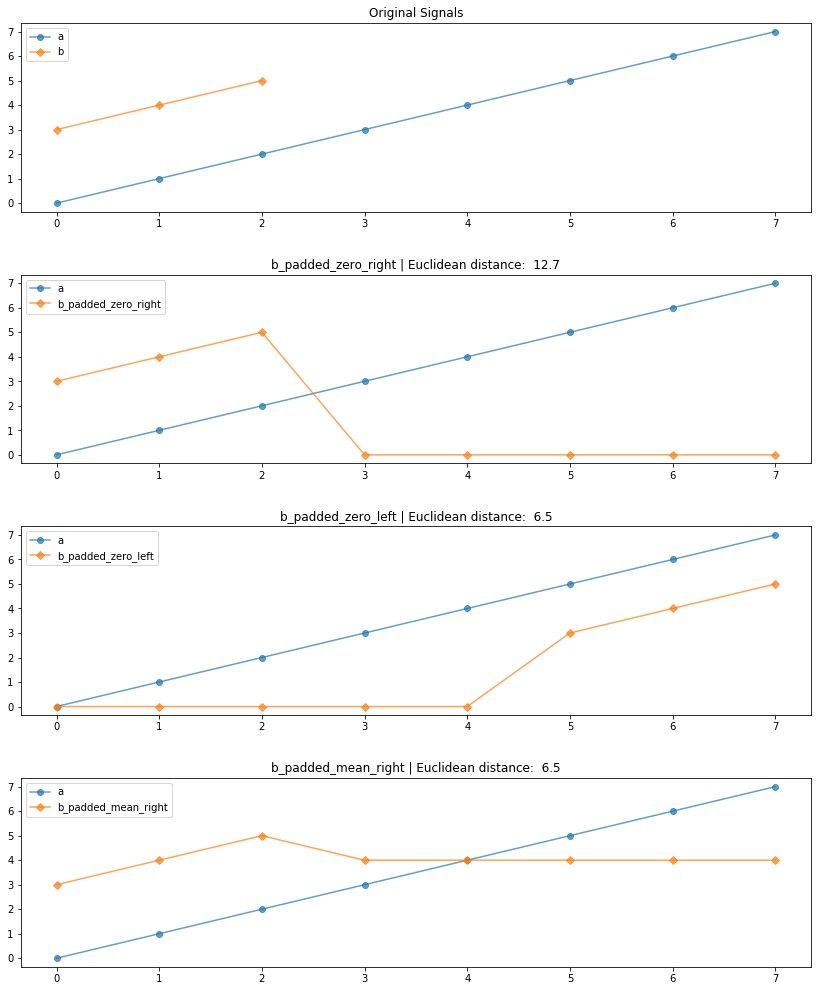

In [49]:
num_charts = 4
chart_height = 3.6
fig, axes = plt.subplots(num_charts, 1, figsize=(12, num_charts * chart_height))
    
# Turn on markers only if < 50 points
a_marker = None
b_marker = None
if len(a) < 50:
    a_marker = "o"
    b_marker = "D"

axes[0].plot(a, alpha=0.7, label="a", marker="o")
axes[0].plot(b, alpha=0.7, label="b", marker="D")
axes[0].legend()
axes[0].set_title(f"Original Signals")

axes[1].plot(a, alpha=0.7, label="a", marker="o")
axes[1].plot(b_padded_zero_right, alpha=0.7, label="b_padded_zero_right", marker="D")
axes[1].legend()
axes[1].set_title(f"b_padded_zero_right | Euclidean distance: {distance.euclidean(a, b_padded_zero_right): .1f}")

axes[2].plot(a, alpha=0.7, label="a", marker="o")
axes[2].plot(b_padded_zero_left, alpha=0.7, label="b_padded_zero_left", marker="D")
axes[2].legend()
axes[2].set_title(f"b_padded_zero_left | Euclidean distance: {distance.euclidean(a, b_padded_zero_left): .1f}")

axes[3].plot(a, alpha=0.7, label="a", marker="o")
axes[3].plot(b_padded_mean_right, alpha=0.7, label="b_padded_mean_right", marker="D")
axes[3].legend()
axes[3].set_title(f"b_padded_mean_right | Euclidean distance: {distance.euclidean(a, b_padded_mean_right): .1f}")

fig.tight_layout(pad=3)

# Cross-correlation

[Cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation) is a measure of similarity between two signals. It works by sliding one signal across another and finding the optimal match. This is also known as a sliding dot product or sliding inner-product and is closely related to [convolution](https://en.wikipedia.org/wiki/Convolution). As Wikipedia notes, cross-correlation is most often used to search a long signal for a potential shorter, known signal and is commonly used in pattern recognition, computer vision, and beyond.


<center><img src="assets/movies/CrossCorrelationAnimation_Robosub_EECS_WSU.gif" style="margin-bottom: 10px; margin-top:10px"/></center>
<center>A cross-correlation "slides" one signal along another to determine maximal overlap. Animated gif from <a href="http://robosub.eecs.wsu.edu/wiki/ee/hydrophones/start">WSU's RoboSub project</a>.</center>



## Simple example

Let's take a look at a simple example with two signals slightly different signals. The NumPy implementation of cross-correlation is called [`correlate`](https://numpy.org/doc/stable/reference/generated/numpy.correlate.html) and returns an array of cross correlation results for all shift positions of b.

In [50]:
a = [0, 1, 2, 3, 4, 3, 2]
b = [0, 0, 1, 2, 3, 4, 3]
correlate_result = np.correlate(a, b, 'full')
b_shift_positions = np.arange(-len(a) + 1, len(b))
print(b_shift_positions) # The shift positions of b
print(correlate_result)


[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
[ 0  3 10 20 32 39 38 28 16  7  2  0  0]


It's useful to explore cross-correlation visually (similar to the animation above). We will create a three-row graph with:
- (Top) The original signals `a` and `b` with a euclidean distance calculation
- (Mid) The cross-correlation result where the x-axis shows different integer shift (or lag) positions of signal `b` and the y-axis shows the cross-correlation result (a higher value indicates a stronger correlation or match at that shift position) 
- (Bottom) The original signal `a` with shifted signal `b` and a recalculation of euclidean distance between `a` and the shifted `b` signal

len(a) 7 len(b) 7 len(correlate_result) 13
[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
[ 0  3 10 20 32 39 38 28 16  7  2  0  0]
best_correlation_index 5 shift_amount_debug -1 shift_amount -1


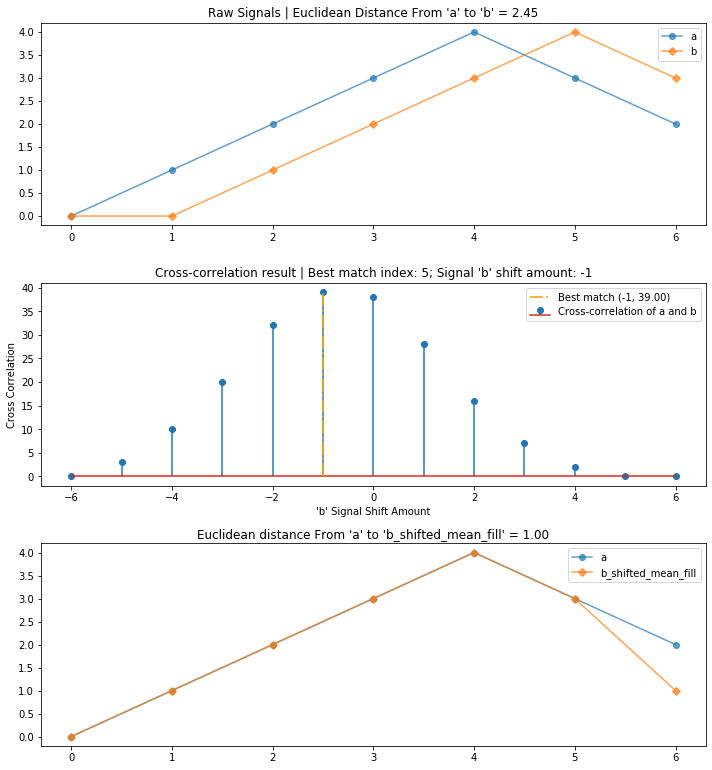

In [51]:
compare_and_plot_signals_with_alignment(a, b)

Using cross-correlation, we reduced the overall euclidean distance between the two signals from 2.45 to 1 by first aligning and then comparing them.

## Methods to shift a signal

But, you may wonder, if we are shifting signal `b`, what values should we inject into the open array positions? Good question!

And again, the answer depends. If your signals are highly periodic, then using a [roll](https://numpy.org/doc/stable/reference/generated/numpy.roll.html) might work best—which shifts a signal by wrapping values off the end of the array to the beginning. Or, similar to padding, you could shift in zeros or the signal mean (or some other statistical value). 

Let's compare three different signal shifting approaches below:
- Shifting in the mean value
- Shifting in zero
- Rolling using [np.roll](https://numpy.org/doc/stable/reference/generated/numpy.roll.html)


len(a) 7 len(b) 7 len(correlate_result) 13
[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
[ 0  3 10 20 32 39 38 28 16  7  2  0  0]
best_correlation_index 5 shift_amount_debug -1 shift_amount -1


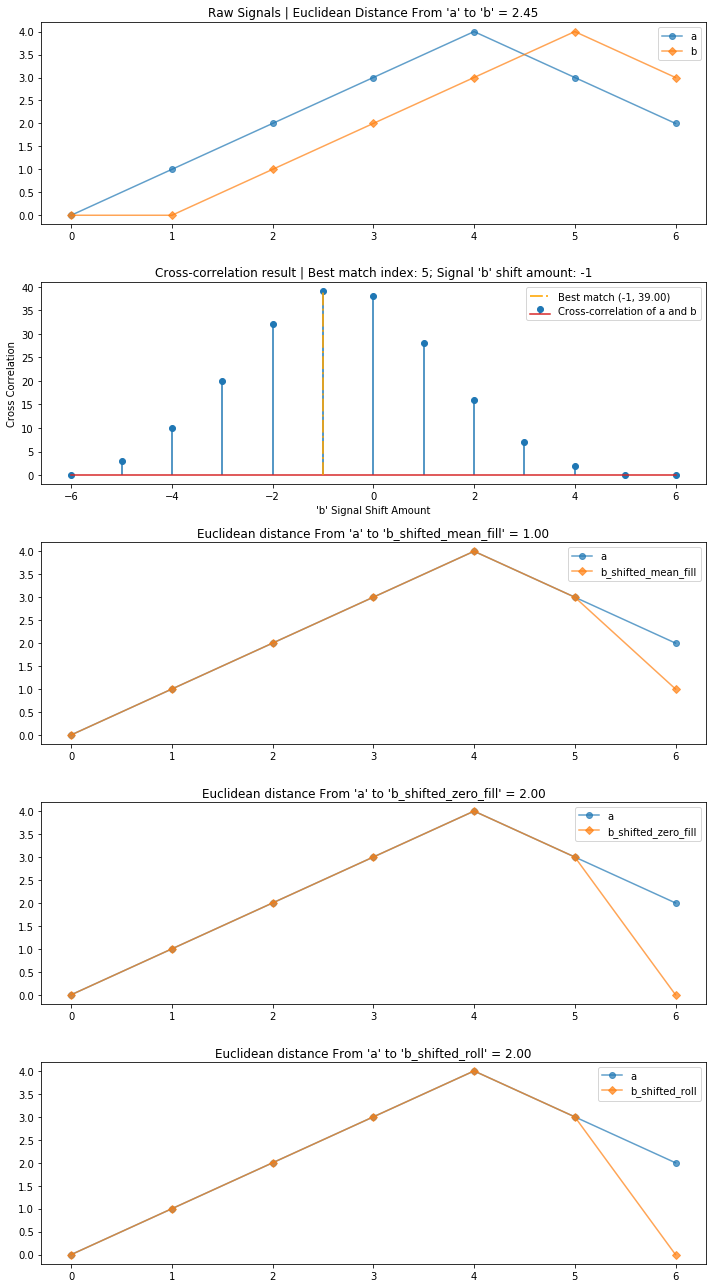

In [52]:
a = [0, 1, 2, 3, 4, 3, 2]
b = [0, 0, 1, 2, 3, 4, 3]
compare_and_plot_signals_with_alignment(a, b, bshift_method = 'all')

## Shifting via a roll

Let's look at a few more examples, which benefit from shifting by "rolling" or "wrapping" signal `b`.

We'll begin with a curated example: two signals `a` and `b` that are similar but slightly offset.

len(a) 17 len(b) 17 len(correlate_result) 33
best_correlation_index 8 shift_amount_debug -8 shift_amount -8


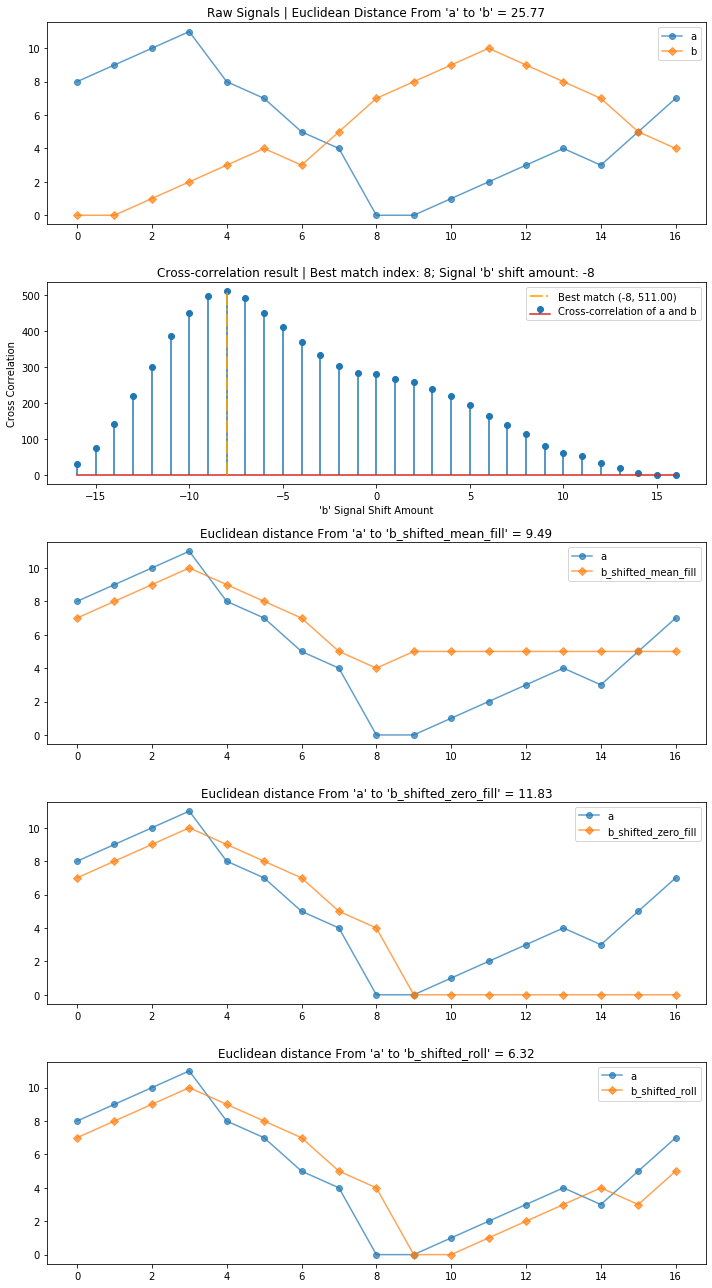

In [53]:
a = [8, 9, 10, 11, 8, 7, 5, 4, 0, 0, 1, 2, 3, 4, 3, 5, 7]
b = [0, 0, 1, 2, 3, 4, 3, 5, 7, 8, 9, 10, 9, 8, 7, 5, 4]
compare_and_plot_signals_with_alignment(a, b, bshift_method = "all")

Here, roll works best. What about with our signals?

## Sine and cosine waves

A cosine wave is simply a sine wave shifted by a quarter period (or $\frac{π}{2}$). Can we use cross-correlation to align them?

Yes!

200
len(a) 200 len(b) 200 len(correlate_result) 399
best_correlation_index 209 shift_amount_debug 10 shift_amount 10


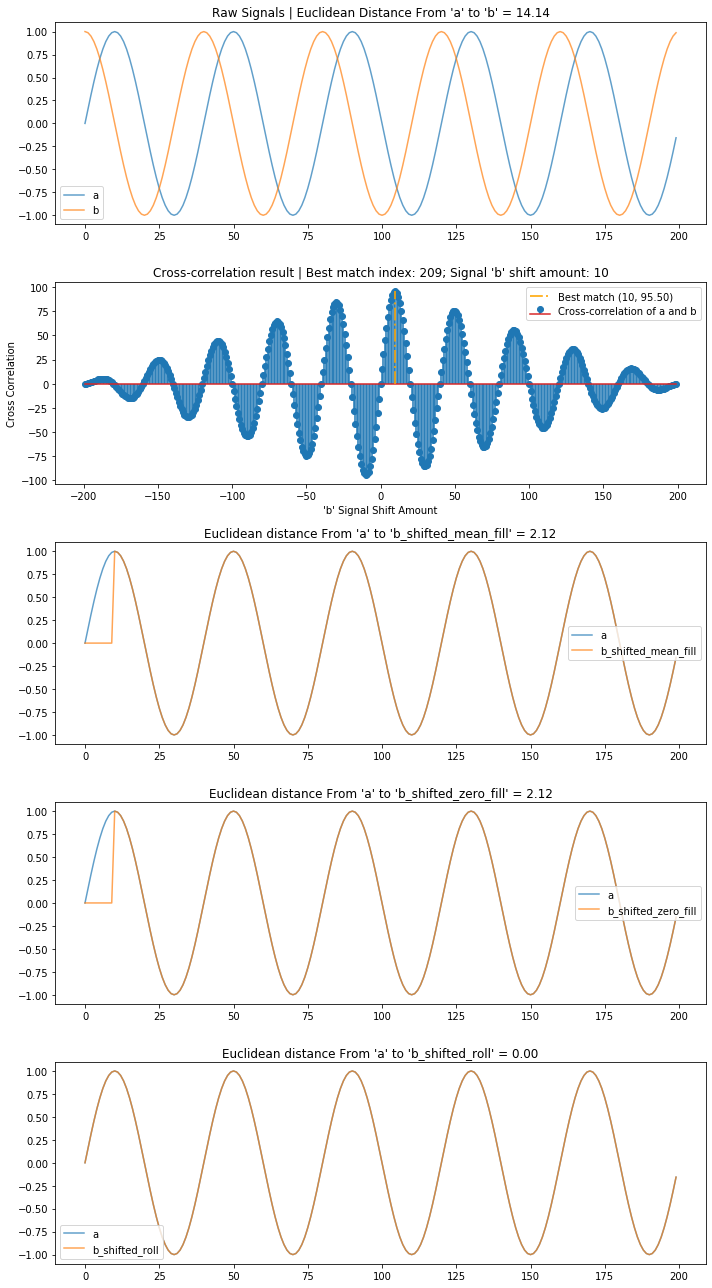

In [54]:
# Create and plot a simple sine and cos wave
total_time_in_secs = 1
sampling_rate = 200
freq = 5

sine_wave = makelab.signal.create_sine_wave(freq, sampling_rate, total_time_in_secs)
cos_wave = makelab.signal.create_cos_wave(freq, sampling_rate, total_time_in_secs)
print(len(cos_wave))
compare_and_plot_signals_with_alignment(sine_wave, cos_wave, bshift_method = 'all')

## Sawtooth wave
Let's try the same thing with a sawtooth wave.

len(a) 200 len(b) 200 len(correlate_result) 399
best_correlation_index 169 shift_amount_debug -30 shift_amount -30


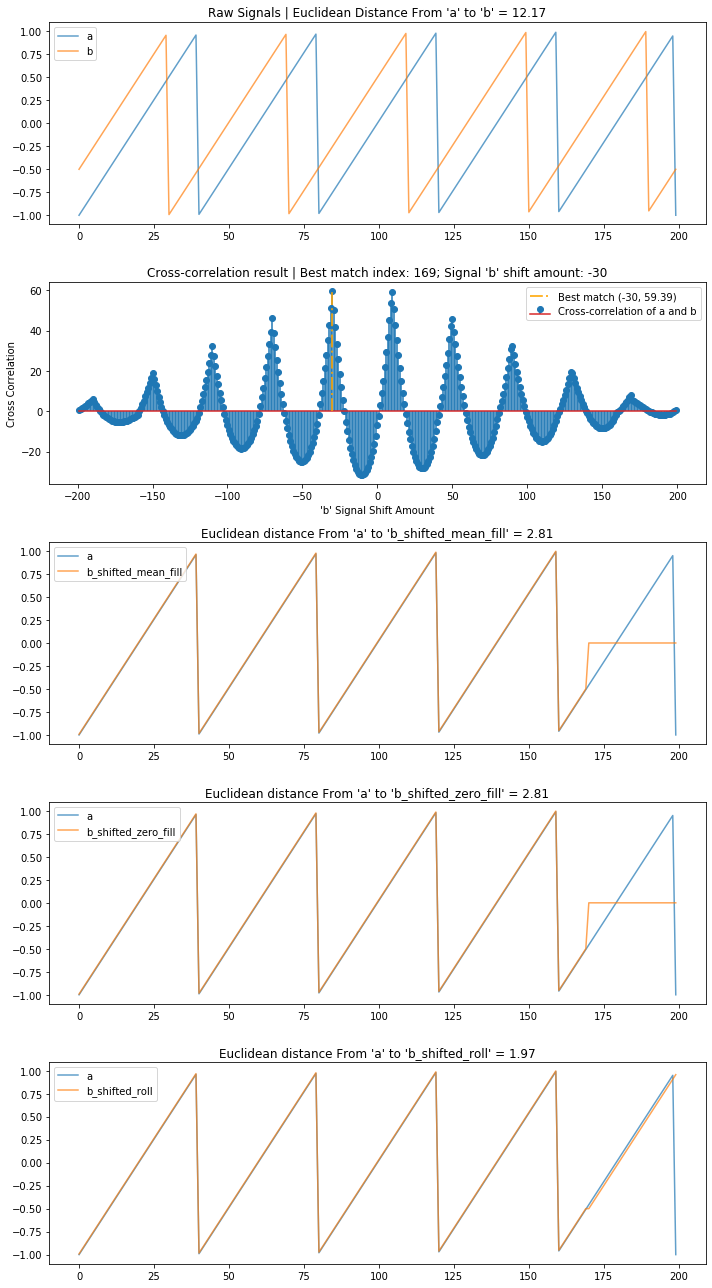

In [55]:
total_time_in_secs = 1
sampling_rate = 200
freq = 5

t = np.linspace(0, total_time_in_secs, sampling_rate)
sawtooth_a = sp.signal.sawtooth(2 * np.pi * freq * t)
sawtooth_b = sp.signal.sawtooth(2 * np.pi * freq * t + np.pi/2)

compare_and_plot_signals_with_alignment(sawtooth_a, sawtooth_b, bshift_method = 'all')

## Playing with random data

Finally, it may be useful for you to play with some random data to further increase your understanding and test your intuition.

len(a) 7 len(b) 7 len(correlate_result) 13
[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
[ 4  4  2  6 15 12 12 15 16 12 11  7  3]
best_correlation_index 8 shift_amount_debug 2 shift_amount 2


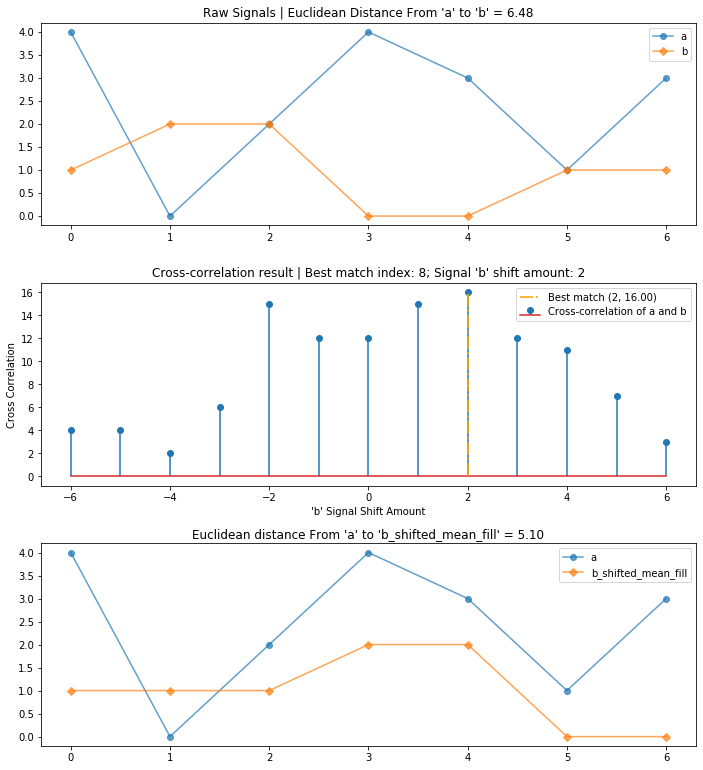

In [60]:
np.random.seed(None)
a = np.random.randint(0, 5, 7)
b = np.random.randint(0, 5, 7)
compare_and_plot_signals_with_alignment(a, b)

## Exercise: Using cross correlation to find a subsequence

In this example, we attempt to use cross correlation to find the best match between an audio recording of a single pluck of the 'A' string on a guitar and a separate audio recording of all six strings plucked in sequence (E, A, D, G, B, E). Typically, you would preprocess both signals and likely use a frequency analysis for this task; however, we are just going to use cross correlationon the raw signal (for a simple demonstration)!

Read in data/audio/Guitar_Pluck_SixStringsInSequence.wav
Sampling rate: 3000 Hz
Number of channels = 1
Total samples: 143070


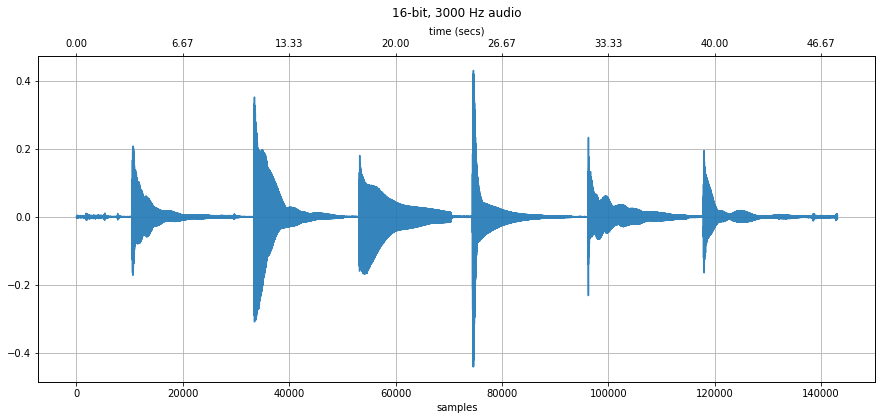

In [61]:
# Read in the six string pluck audio file
read_in_sampling_rate = 3000 # 3,000 Hz is the lowest sampling rate that will play in Chrome

sound_file = 'data/audio/Guitar_Pluck_SixStringsInSequence.wav'
guitar_pluck_six_strings, sampling_rate = librosa.load(sound_file, sr=read_in_sampling_rate)
print(f"Read in {sound_file}")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Number of channels = {len(guitar_pluck_six_strings.shape)}")
print(f"Total samples: {guitar_pluck_six_strings.shape[0]}")

# Notice how you can see the six strings being plucked
# The 'A' string is the second string on the guitar, so it's the second
# sound envelope showing in the visualization
# Listen to the recording as well
makelab.signal.plot_signal(guitar_pluck_six_strings, sampling_rate)
ipd.Audio(guitar_pluck_six_strings, rate=sampling_rate)

Read in data/audio/Guitar_AString_Pluck.wav
Sampling rate: 3000 Hz
Number of channels = 1
Total samples: 30409


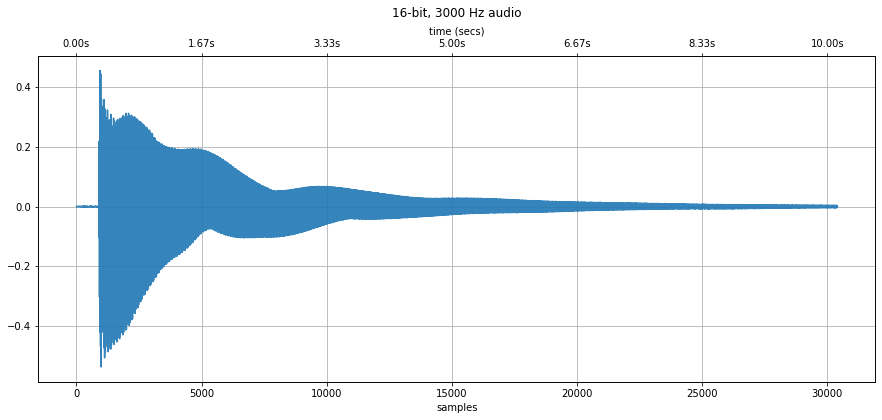

In [62]:
# Read in the A string pluck audio file
sound_file = 'data/audio/Guitar_AString_Pluck.wav'
guiter_pluck_a_string, sampling_rate = librosa.load(sound_file, sr=read_in_sampling_rate)
print(f"Read in {sound_file}")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Number of channels = {len(guiter_pluck_a_string.shape)}")
print(f"Total samples: {guiter_pluck_a_string.shape[0]}")
makelab.audio.plot_signal(guiter_pluck_a_string, sampling_rate)
ipd.Audio(guiter_pluck_a_string, rate=sampling_rate)

len(a) 143070 len(b) 143070 len(correlate_result) 286139
best_correlation_index 175560 shift_amount_debug 32491 shift_amount 32491


C:\Users\jonfr\Anaconda3\lib\site-packages\ipykernel_launcher.py:174: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


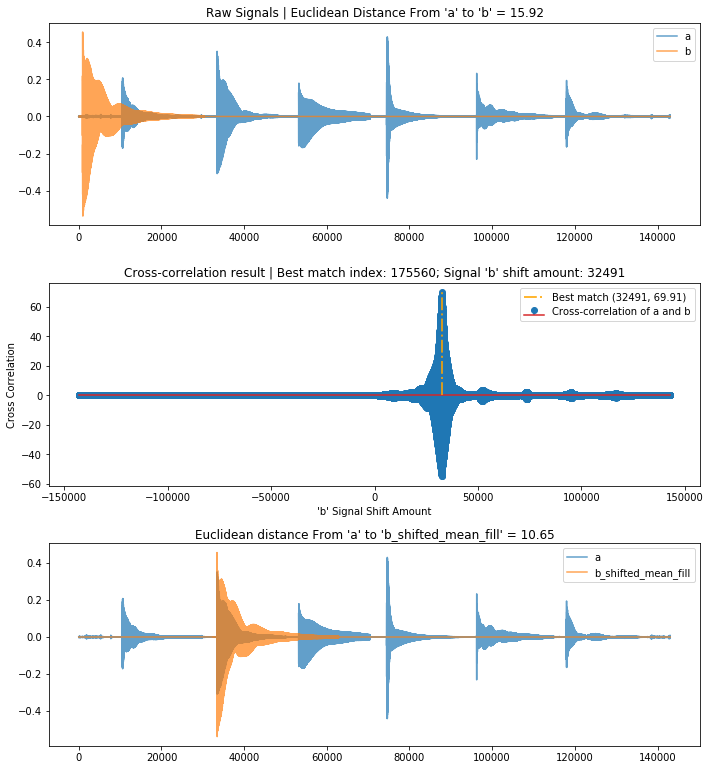

In [63]:
# Convert both signals to mono and then compare them
a = makelab.audio.convert_to_mono(guitar_pluck_six_strings)
b = makelab.audio.convert_to_mono(guiter_pluck_a_string)

# If we appropriately find guiter_pluck_a_string in guitar_pluck_six_strings
# then we will shift b to align with a at the second plucked string (which is the A string)
compare_and_plot_signals_with_alignment(a, b, pad_function = pad_zeros_right)

# Dynamic Time Warping

Dynamic time warping (DTW) is a popular, alternative method for measuring similarity between two signals in the time domain. It works by "warping" the x-axis between two signals to find the closest y-value match. Please watch this [video](https://youtu.be/_K1OsqCicBY) by Thales Körting for more details on the algorithm. 

<img src="assets/images/Korting_HowDTWworks_YouTube.png" width="800" alt="Dynamic time warping video"/>
<center>Watch <a href="https://youtu.be/_K1OsqCicBY">this video</a> by Thales Körting to learn more about DTW</center>

The naive DTW algorithm is computationally expensive both in time and space—$O(N M)$ where $N$ and $M$ are the length of the two sequences—but provides an optimal match between two time-domain signals.

There are a number of optimized DTW approaches, including [FastDTW](https://github.com/rmaestre/FastDTW), which provides optimal or near-optimal alignments with $O(N)$ time and memory based. The [fastdtw](https://pypi.org/project/fastdtw/) Python package, which we use below, is based on Salvador and Chan's FastDTW paper from 2007.

## References
- Stan Salvador, and Philip Chan. [FastDTW: Toward accurate dynamic time warping in linear time and space.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.432.4253&rep=rep1&type=pdf#page=64) Intelligent Data Analysis 11.5 (2007): 561-580.

## FastDTW
The Python implementation of FastDTW is on github [here](https://github.com/slaypni/fastdtw). 

The primary function is:

```
def fastdtw(a, b, radius=1, dist=None):
```

Which takes in signals `a` and `b` along with a `radius` (search area) and the `dist` (distance function). A large radius will increase the warping amount but slow down the algorithm. A radius equal to `max(a,b)` will result in a full DTW calculation.

`fastdtw` returns the DTW distance between `a` and `b` as well as the path `(x, y)` through the distance matrix.

In [64]:
from fastdtw import fastdtw

a = [0, 1, 2, 3, 4, 3, 2]
b = [0, 0, 1, 2, 3, 4, 3]
d, path = fastdtw(a, b, dist=distance.euclidean)
print(d)
print(path)

1.0
[(0, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 6)]


# Sandbox

- Consider visualizing like top-3 lags?
- As an exercise, have students align touch or mouse gesture data. Could be from [Wobbrock's $1 project](http://depts.washington.edu/acelab/proj/dollar/index.html) or another [dataset](https://sites.google.com/site/adriendelaye/home/pen-and-touch-datasets) 
- Add in examples uses of these algorithms from HCI/UbiComp papers
    - Froehlich, J. E., Neumann, J., & Oliver, N. (2009, June). [Sensing and predicting the pulse of the city through shared bicycling](https://www.aaai.org/ocs/index.php/IJCAI/IJCAI-09/paper/viewFile/578/910). In Twenty-First International Joint Conference on Artificial Intelligence.

## Lex Fridman faster cross correlation

In [14]:
import numpy as np
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
 
def cross_correlation_using_fft(x, y):
    f1 = fft(x)
    f2 = fft(np.flipud(y))
    cc = np.real(ifft(f1 * f2))
    return fftshift(cc)
 
# shift &lt; 0 means that y starts 'shift' time steps before x # shift &gt; 0 means that y starts 'shift' time steps after x
def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift